In [1]:
! pip install nltk
! pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
from matplotlib.gridspec import GridSpec
import re
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DeltaLakeExample") \
    .master("spark://dbms-spark-master:7077") \
    .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.2.0,org.apache.hadoop:hadoop-aws:3.3.4") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://dbms-minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minio_user") \
    .config("spark.hadoop.fs.s3a.secret.key", "minio_password") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

In [4]:
delta_table = "unified_cv"
minio_bucket='cleaned-bucket'
table_location = f"s3a://{minio_bucket}/unified/{delta_table}"

df = spark.read.format("delta").load(table_location)
df = df.toPandas()

In [5]:
df['cleaned_resume'] = ''
df.head()

,Category,Skill,Company,Project,cleaned_resume
0,Data Science,"[javascript, jquery, python]",Ernst & Young LLP,[(Core member of a team helped in developing a...,
1,Data Science,"[python, statsmodels, aws, learning, sklearn, ...",Matelabs,[],
2,Data Science,"[analysis, excel, learning, mathematics, pytho...",THEMATHCOMPANY,[],
3,Data Science,"[programming, retail, marketing, scm, sql, lea...",Deloitte USI,[],
4,Data Science,"[structure, c, analysis, python, java, managem...",Itechpower,[],


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        962 non-null    object
 1   Skill           962 non-null    object
 2   Company         962 non-null    object
 3   Project         962 non-null    object
 4   cleaned_resume  962 non-null    object
dtypes: object(5)
memory usage: 37.7+ KB


In [7]:
print ("Displaying the distinct categories of resume:\n\n ")
print (df['Category'].unique())

Displaying the distinct categories of resume:

 
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [8]:
print ("Displaying the distinct categories of resume and the number of records belonging to each category:\n\n")
print (df['Category'].value_counts())

Displaying the distinct categories of resume and the number of records belonging to each category:


Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64


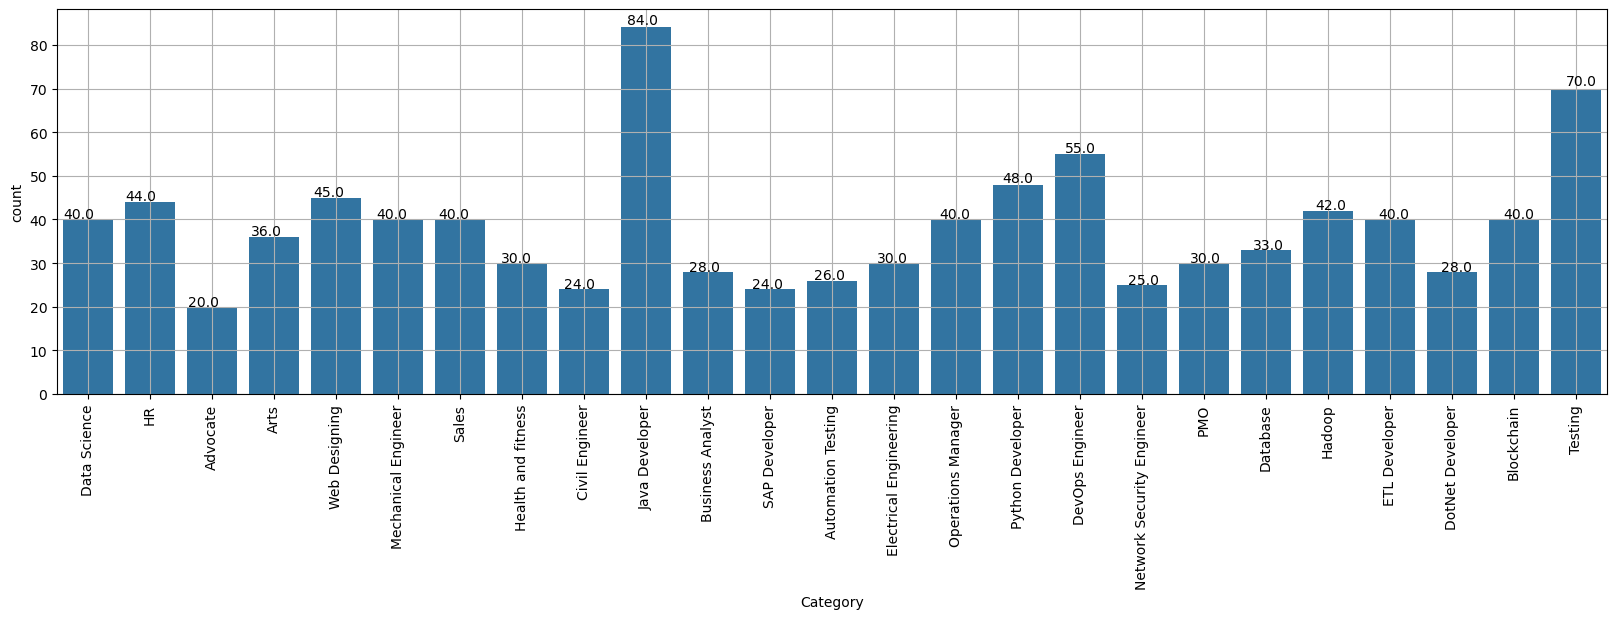

In [9]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=df)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.grid()

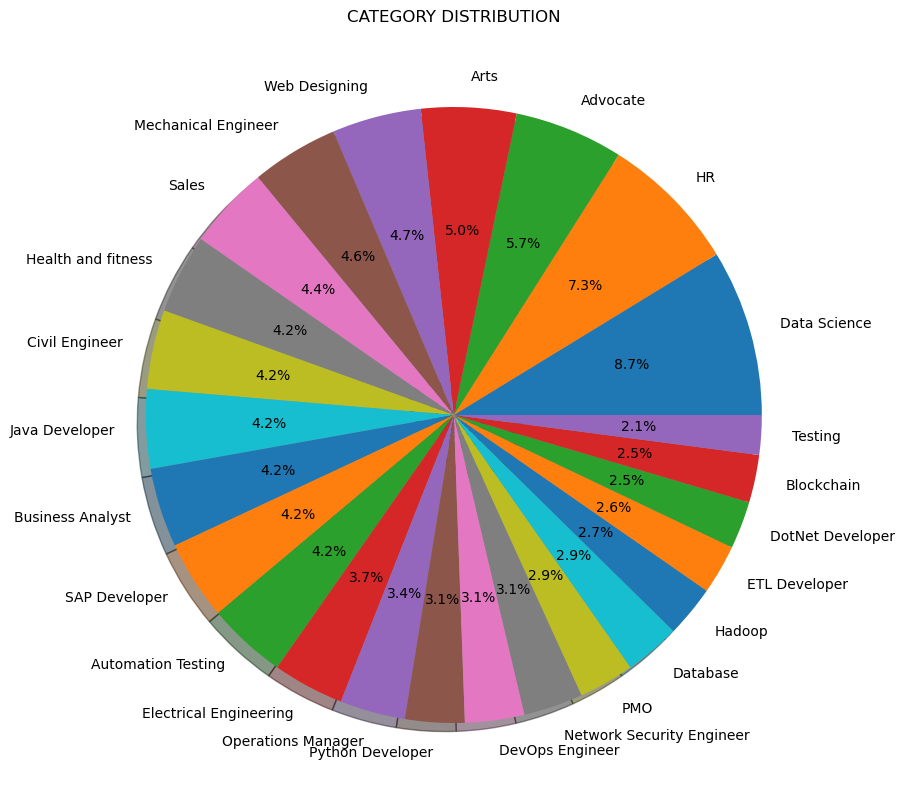

In [10]:
targetCounts = df['Category'].value_counts()
targetLabels  = df['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(22,22))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True)
plt.show()

In [11]:
df.duplicated(subset=['Resume']).value_counts()

KeyError: Index(['Resume'], dtype='object')

In [ ]:
df[df.duplicated()==True]

In [ ]:
df.drop_duplicates(subset=['Resume'], keep='first',inplace = True)
df.reset_index(inplace=True,drop=True)
df.head()

In [ ]:
df.info()

In [ ]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
    
df['cleaned_resume'] = df.Resume.apply(lambda x: cleanResume(x))

In [ ]:
df.head()

In [ ]:
df_d=df.copy()

In [ ]:
import nltk
import string
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = df['Resume'].values
cleanedSentences = ""
for records in Sentences:
    cleanedText = cleanResume(records)
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

In [ ]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [ ]:
df.head()

In [ ]:
df.Category.value_counts()

In [ ]:
df_d.Category.value_counts() 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

requiredText = df['cleaned_resume'].values
requiredTarget = df['Category'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english')
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print ("Feature completed .....")

X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=42, test_size=0.2,
                                                 shuffle=True, stratify=requiredTarget)
print(X_train.shape)
print(X_test.shape)

In [ ]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set:     {:.2f}'.format(clf.score(X_test, y_test)))

In [ ]:
print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_train, clf.predict(X_train))))

In [ ]:
print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))